In [30]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

Getting dataset

In [13]:
data = pd.read_csv("/Users/lucasvilsen/Desktop/DTU/MachineLearning&DataMining/StandardizedDataFrameWithNansFilled.csv")
data["Status"] = [1 if stat == "Developed" else 0 for stat in data["Status"]]
data.head()

,Unnamed: 0,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0,Afghanistan,2015,0,-0.444372,0.791452,0.268778,-1.139938,-0.335513,-0.110366,-0.964550,0.255316,-3.254219,0.911749,-0.723742,-0.32339,2.812651,2.772807,-0.725277,-0.579832
1,1,Afghanistan,2014,0,-0.980783,0.855926,0.285738,-1.139938,-0.334384,-0.168095,-0.989641,0.274014,-1.039197,0.919893,-0.850094,-0.32339,2.880918,2.817423,-0.739924,-0.610466
2,2,Afghanistan,2013,0,-0.980783,0.831748,0.302697,-1.139938,-0.334537,-0.173502,-1.014732,0.292712,-0.868811,0.899533,-0.765859,-0.32339,2.926429,2.862039,-0.769218,-0.641099
3,3,Afghanistan,2012,0,-1.022854,0.863985,0.328137,-1.139938,-0.332040,0.032040,-1.039823,0.317642,-0.655828,1.058344,-0.639507,-0.32339,2.971940,2.928963,-0.803395,-0.671733
4,4,Afghanistan,2011,0,-1.054408,0.888163,0.345097,-1.139938,-0.367800,0.051748,-1.059895,0.342573,-0.613232,0.793659,-0.597390,-0.32339,3.040207,2.973578,-0.847336,-0.763634


In [21]:
data.columns

Index(['Unnamed: 0', 'Country', 'Year', 'Status', 'Life expectancy ',
       'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [69]:
columns = list(data.columns)
x_columns = [data[column].to_list() for column in [columns[3]] + columns[5:]]

xs = torch.tensor([[x[index] for x in x_columns] for index in range(len(x_columns[0]))])
ys = torch.tensor(data["Life expectancy "].to_list())
xs.size(), ys.size()

(torch.Size([2938, 16]), torch.Size([2938]))

In [71]:
# So the following is true:
input_size = 16
output_size = 1
hs_to_test = [1, 2, 5, 10, 20, 30, 40, 50, 75, 100, 200]

Make NN structure

In [196]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, h, output_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, h),
            nn.Tanh(),  
            nn.Linear(h, output_size),
        )

    def forward(self, x):
        return self.layers.forward(x)

Splitting test and train data

In [197]:
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.1)

In [198]:
len(x_train), len(x_test)

(2644, 294)

We train each NN for 10 epochs of the whole dataset to first find the best h

In [202]:
learning_rate = 2e-4
epochs = 500
batch_size = 32

h = 200

model = SimpleNN(input_size, h, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [203]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader):
    losses = []
    eval_loss = []
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad() 
            outputs = model(inputs)
            outputs = torch.cat(list(outputs), dim=0)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            losses.append(abs(loss.item()))
        eval_loss.append(eval_model(model))
    plt.plot(range(len(losses)), losses, label = "loss")
    plt.plot(range(0, len(eval_loss) * len(train_loader), len(train_loader)), eval_loss, label = "eval loss")
    plt.show()

def eval_model(model):
    distances = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in list(zip(x_test, y_test)):
            outputs = model(inputs)
            distances.append(abs(outputs - labels))

    return sum(distances)/len(distances)

100%|██████████| 500/500 [00:37<00:00, 13.35it/s]


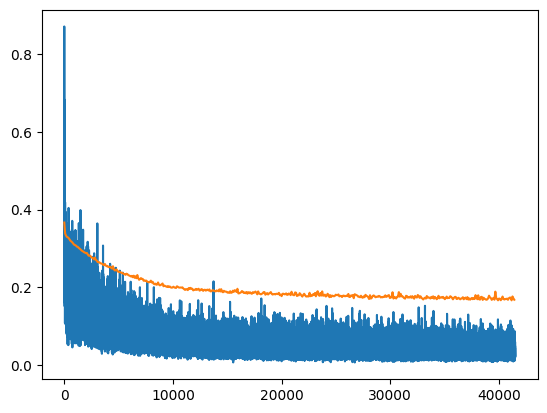

tensor([0.1677])

In [204]:
train_model(model, criterion, optimizer, train_loader)
eval_model(model)

### Performance logging

We now do K-fold to find the best performing NN model